In [3]:
import pandas as pd

# 과제 : OriginalTweet을 분석하여 Sentiment 분류 모델 만들고 성능 파악하기!
train_data = pd.read_csv("/content/Corona_NLP_train.csv", encoding="latin")

docs = train_data["OriginalTweet"].to_numpy()

array(['@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8',
       'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P',
       "My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",
       "Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The 

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
token = Tokenizer()
token.fit_on_texts(docs)
print(token.word_index) # 단어마다 정수값을 할당

{'the': 1, 'to': 2, '\r\r': 3, 't': 4, 'co': 5, 'and': 6, 'https': 7, 'of': 8, 'a': 9, 'in': 10, 'coronavirus': 11, '19': 12, 'covid': 13, 'for': 14, 'is': 15, 'are': 16, 'on': 17, 'you': 18, 'i': 19, 'this': 20, 'at': 21, 'prices': 22, 'food': 23, 'supermarket': 24, 'store': 25, 'with': 26, 'that': 27, 'grocery': 28, 'we': 29, 'have': 30, 'as': 31, 'be': 32, 'it': 33, 'people': 34, 'from': 35, 'amp': 36, 'all': 37, 'covid19': 38, 'consumer': 39, 'your': 40, 'not': 41, 'will': 42, 'my': 43, 'our': 44, 'up': 45, 'out': 46, 'they': 47, 'has': 48, 'or': 49, 'can': 50, 'by': 51, 'more': 52, 'shopping': 53, 'but': 54, 'if': 55, 'online': 56, 'how': 57, 'their': 58, 'during': 59, 'pandemic': 60, 'so': 61, 'now': 62, 'no': 63, 'get': 64, 'about': 65, 'need': 66, 'who': 67, 'what': 68, 'just': 69, 'panic': 70, 'workers': 71, 'us': 72, 'do': 73, 'like': 74, 'time': 75, 'sanitizer': 76, 'was': 77, 'home': 78, 'an': 79, 'demand': 80, 'when': 81, 'go': 82, 's': 83, 'some': 84, 'help': 85, 'hand': 

In [6]:
# 이제 정수로 이루어진 배열을 얻자
x = token.texts_to_sequences(docs)
type(x)

list

In [8]:
max_len = 0

# 문장 하나씩 둘러보면서, 가장 긴 문장의 길이값을 갱신한다.
for i in range(len(x)) :
  if len(x[i]) > max_len :
    max_len = len(x[i])

print("가장 단어가 많은 트윗의 단어 수 :", max_len)

가장 단어가 많은 문장의 단어 수 : 69


In [9]:
padded_x = pad_sequences(x, 40, truncating="pre")
print("\n패딩 결과 :\n", padded_x)


패딩 결과 :
 [[    0     0     0 ...     4     5 24795]
 [    0     0   535 ...    41   115   250]
 [    0     0     0 ...     4     5 24797]
 ...
 [    0     0     0 ...    85    72    46]
 [    0     0     0 ...    11    38    11]
 [ 3357  1343    17 ...     2    18 85198]]


In [10]:
# 임베딩에 입력될 단어의 수를 지정합니다.
word_size = len(token.word_index) + 1

# 모델 만들기
model = Sequential()
model.add(Embedding(word_size, 180, input_length=40))
model.add(Dropout(0.3))
model.add(LSTM(8, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(8))
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
# 타겟에 대한 원-핫 인코딩
classes = pd.get_dummies(train_data['Sentiment'])

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,False,False,False,True,False
1,False,False,False,False,True
2,False,False,False,False,True
3,False,False,False,False,True
4,True,False,False,False,False
...,...,...,...,...,...
41152,False,False,False,True,False
41153,True,False,False,False,False
41154,False,False,False,False,True
41155,False,False,False,True,False


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(padded_x[:15000], classes, epochs=200, validation_split=0.25, callbacks=[early_stopping_callback])

Epoch 1/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 226ms/step - accuracy: 0.3227 - loss: 1.5118 - val_accuracy: 0.4781 - val_loss: 1.2566
Epoch 2/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.5793 - loss: 1.0549 - val_accuracy: 0.5245 - val_loss: 1.1299
Epoch 3/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 229ms/step - accuracy: 0.7394 - loss: 0.7372 - val_accuracy: 0.5829 - val_loss: 1.0745
Epoch 4/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 80s 224ms/step - accuracy: 0.8497 - loss: 0.4870 - val_accuracy: 0.5675 - val_loss: 1.1672
Epoch 5/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 79s 225ms/step - accuracy: 0.9014 - loss: 0.3404 - val_accuracy: 0.5781 - val_loss: 1.2641
Epoch 6/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 80s 227ms/step - accuracy: 0.9399 - loss: 0.2241 - val_accuracy: 0.5707 - val_loss: 1.4065
Epoch 7/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 227ms/step - accuracy: 0.9491 - loss: 0.1784 - val_accuracy: 0.5603 - val_loss: 1.5443
Epoch 8/200
352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.9628 -

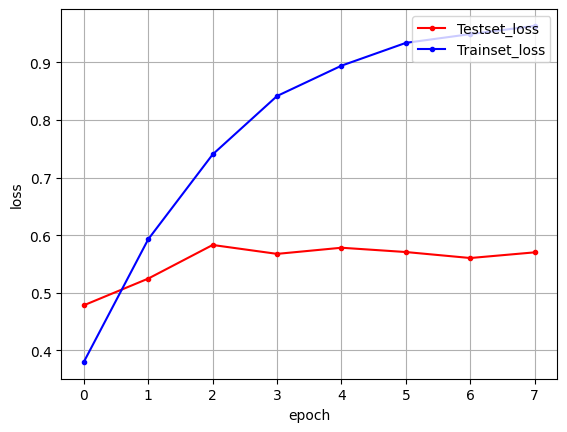

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_accuracy']
y_loss = history.history['accuracy']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [16]:
classes_str = ["Extremely Negative", "Extremely Positive",	"Negative",	"Neutral","Positive"]
sample = 999

pred_x = token.texts_to_sequences(docs[sample:sample+1])
pred_x = pad_sequences(pred_x, 40)

pred = model.predict(pred_x)
print("예측 결과는 :", classes_str[np.argmax(pred)])
print("실제 감정은 :\n", classes.iloc[sample])
print("내용은: \n", docs[sample])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
예측 결과는 : Negative
실제 감정은 :
 Extremely Negative    False
Extremely Positive    False
Negative               True
Neutral               False
Positive              False
Name: 999, dtype: bool
내용은: 
 @WinAtLifeOnline Rest assured that our team is tirelessly working to have these removed! Our policy prohibits sellers from profiting on human tragedy and natural disaster. Here is an article with the action we are taking: https://t.co/MkRg4wpd8l - Mindy
